In [2]:
import pandas as pd
from joblib import Memory
from datetime import datetime
memory = Memory(f"cachedir/{datetime.today().date()}", compress=True)

@memory.cache
def cached_read(url):
    return pd.read_csv(url)

In [3]:
## load
df = cached_read("https://raw.githubusercontent.com/robert-koch-institut/COVID-19-Impfungen_in_Deutschland/master/Aktuell_Deutschland_Landkreise_COVID-19-Impfungen.csv")
df

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-4239711195.cached_read...
cached_read('https://raw.githubusercontent.com/robert-koch-institut/COVID-19-Impfungen_in_Deutschland/master/Aktuell_Deutschland_Landkreise_COVID-19-Impfungen.csv')


/tmp/ipykernel_261/4239711195.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(url)


______________________________________________________cached_read - 9.4s, 0.2min


,Impfdatum,LandkreisId_Impfort,Altersgruppe,Impfschutz,Anzahl
0,2020-12-27,1003,18-59,1,9
1,2020-12-27,1003,60+,1,19
2,2020-12-27,1053,18-59,1,13
3,2020-12-27,1053,60+,1,200
4,2020-12-27,1055,18-59,1,20
...,...,...,...,...,...
922025,2022-03-21,16077,12-17,1,5
922026,2022-03-21,16077,12-17,2,5
922027,2022-03-21,16077,18-59,2,6
922028,2022-03-21,16077,18-59,3,28


<AxesSubplot:xlabel='Impfdatum'>

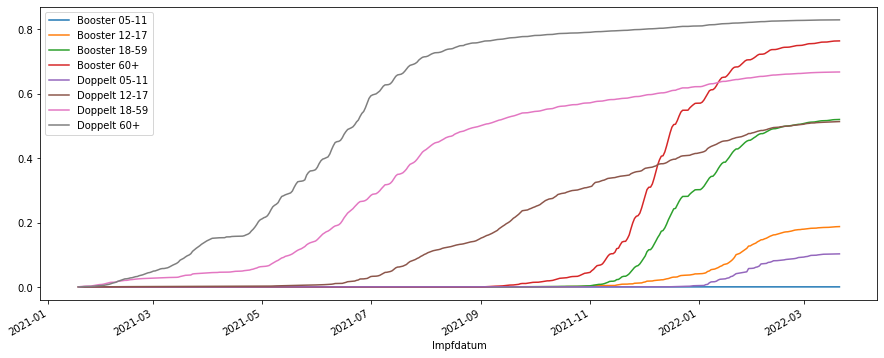

In [6]:
## tranform
df2 = df.copy()
df2["LandkreisId_Impfort"] = df2.LandkreisId_Impfort.astype(int, errors="ignore")
df2 = df2[((df2.LandkreisId_Impfort == 14612) | (df2.LandkreisId_Impfort == "14612")) & (df2.Impfschutz >= 2)]
# Demographics
df2.loc[df2.Altersgruppe == "05-11", "Anzahl"] /= 39020
df2.loc[df2.Altersgruppe == "12-17", "Anzahl"] /= 29150
df2.loc[df2.Altersgruppe == "18-59", "Anzahl"] /= 311960
df2.loc[df2.Altersgruppe == "60+", "Anzahl"] /= 153500

# df2.set_index(("Impfdatum"), inplace=True)
df2["Doppelt"] = df2[df2.Impfschutz == 2]["Anzahl"]
df2["Booster"] = df2[df2.Impfschutz == 3]["Anzahl"]
df2 = df2.filter(("Impfdatum","Doppelt", "Booster", "Altersgruppe"))
# df2.groupby("Impfdatum").sum().cumsum()#.plot()
df2 = df2.groupby(["Impfdatum", "Altersgruppe"]).sum().groupby("Altersgruppe").cumsum()#.rolling(180, min_periods=1).sum()
# df2["geimpft"] = df2["Doppelt"] + df2["Booster"]
# df2["doppelt_anteil"] = df2["Doppelt"] / 561000
# df2["booster_anteil"] = df2["Booster"] / 561000
# df2.groupby("Altersgruppe").plot(y=("doppelt_anteil", "booster_anteil"))
df2 = df2.reset_index().pivot_table(index="Impfdatum", columns="Altersgruppe")
df2.index = pd.to_datetime(df2.index)
df2 = df2.interpolate("time", axis=0).fillna(0)
df2.columns = [' '.join(col).strip() for col in df2.columns.values]
df2.plot(figsize=(15,6))

In [5]:
## save to csv
df2.to_csv("Dresden_Impfungen_Altersgruppen.csv")